## Notebook for applying Data Assimilation on seasonal data (PWP reconstructions)

### Assemble data in the proxy domain using offline (block update) assimilation instead of point-by-point

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705

# Load packages

In [19]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SST model data

In [2]:
# Load model SST data as prior and show data structure
PlioMIP_SST = pd.read_csv('PWP case/PlioMIP_SST.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP_SST.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.50,24.35,22.60,18.74,14.83,10.86
1,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.50,25.29,23.95,20.76,16.37,12.48
2,COSMOS,7.91,6.68,6.38,7.34,9.53,12.23,14.95,15.94,14.94,13.34,11.49,9.58
3,EC-Earth3.3,9.18,7.62,7.41,9.32,13.58,19.22,24.06,25.27,23.56,20.26,16.05,12.13
4,GISS2.1G,4.87,3.58,3.88,6.75,11.21,15.56,18.68,19.39,17.68,14.47,10.53,7.18


## Load monthly SAT model data

In [3]:
# Load model SAT data as prior and show data structure
PlioMIP_SAT = pd.read_csv('PWP case/PlioMIP_SAT.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP_SAT.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4,8.39,8.81,9.63,12.05,15.15,19.61,22.81,22.96,19.02,14.70,11.03,9.13
1,CCSM4-UoT,6.97,7.58,9.96,12.54,16.46,21.92,25.43,24.72,19.69,14.32,9.94,7.02
2,CCSM4-Utr,9.43,9.50,10.88,13.14,16.81,21.09,25.02,24.99,21.79,17.26,12.84,10.15
3,CESM1.2,9.32,9.84,10.56,13.06,16.71,20.91,23.83,23.44,20.11,15.96,12.77,10.38
4,CESM2,10.70,10.44,11.75,13.85,17.69,22.31,25.02,25.18,21.79,17.65,13.99,12.05


### Combine SST and SAT data by modelname

In [4]:
# Merge the datasets of SST and SAT, force suffixes to be added to the column names
PlioMIP = pd.merge(
    PlioMIP_SST.rename(columns = {c: c+'_SST' for c in PlioMIP_SST.columns if c != 'modelname'}),
    PlioMIP_SAT.rename(columns = {c: c+'_SAT' for c in PlioMIP_SAT.columns if c != 'modelname'}),
    on = 'modelname',
    how = 'outer'
)

# Display the combined dataset
PlioMIP.head()

,modelname,ja_SST,fb_SST,mr_SST,ar_SST,my_SST,jn_SST,jl_SST,ag_SST,sp_SST,...,mr_SAT,ar_SAT,my_SAT,jn_SAT,jl_SAT,ag_SAT,sp_SAT,ot_SAT,nv_SAT,dc_SAT
0,CCSM4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.63,12.05,15.15,19.61,22.81,22.96,19.02,14.70,11.03,9.13
1,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.5,24.35,22.60,...,9.96,12.54,16.46,21.92,25.43,24.72,19.69,14.32,9.94,7.02
2,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.5,25.29,23.95,...,10.88,13.14,16.81,21.09,25.02,24.99,21.79,17.26,12.84,10.15
3,CESM1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.56,13.06,16.71,20.91,23.83,23.44,20.11,15.96,12.77,10.38
4,CESM2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.75,13.85,17.69,22.31,25.02,25.18,21.79,17.65,13.99,12.05


### Convert SST model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [5]:
# Apply T47()-function from the D47calib package to all SST columns
# Identify the SST columns
SST_columns = [col for col in PlioMIP.columns if col.endswith('_SST')]

# Apply the conversion function to the SST columns and add new columns for D47 and D47_SE
for col in SST_columns:
    base_col_name = col.replace('_SST', '') # Remove the '_SST' suffix from the column name
    PlioMIP[f'{base_col_name}_D47'], PlioMIP[f'{base_col_name}_D47_SE'] = zip(*PlioMIP[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
D47_columns = [col for col in PlioMIP.columns if col.endswith('_D47')]
D47_se_columns = [col for col in PlioMIP.columns if '_D47_SE' in col]
print("D47 values for all model outcomes:\n", PlioMIP[D47_columns].head())
print("Calibration standard errors for all model outcomes:\n", PlioMIP[D47_se_columns].head())

D47 values for all model outcomes:
      ja_D47    fb_D47    mr_D47    ar_D47    my_D47    jn_D47    jl_D47  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1  0.648316  0.652623  0.651496  0.643531  0.630811  0.613992  0.601033   
2  0.642505  0.646808  0.646093  0.638746  0.626446  0.610876  0.597955   
3       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     ag_D47    sp_D47    ot_D47    nv_D47    dc_D47  
0       NaN       NaN       NaN       NaN       NaN  
1  0.595364  0.600724  0.612897  0.625741  0.639340  
2  0.592525  0.596581  0.606465  0.620618  0.633721  
3       NaN       NaN       NaN       NaN       NaN  
4       NaN       NaN       NaN       NaN       NaN  
Calibration standard errors for all model outcomes:
    ja_D47_SE  fb_D47_SE  mr_D47_SE  ar_D47_SE  my_D47_SE  jn_D47_SE  \
0        NaN        NaN        NaN        NaN        NaN        N

## Calculate the monthly prior for model SST-derived D47 values with propagated uncertainty

In [6]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Set the weights of the data based on the standard errors
weights_monthly = 1 / PlioMIP[[f"{month}_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly to match the headers of the D47 matrix later for multiplication
weights_monthly.columns = [col.replace('_D47_SE', '_D47') for col in weights_monthly.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_D47_monthly = np.array((PlioMIP[[f"{month}_D47" for month in months]] * weights_monthly).sum(axis = 0, skipna = True) / weights_monthly.sum(axis = 0, skipna = True)) # Calculate weighted monthal mean D47 values and convert to numpy array

# Decompose variance within and between model outcomes
model_variances = PlioMIP[[f"{month}_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances = (PlioMIP[[f"{month}_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_monthly = np.cov(PlioMIP[[f"{month}_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_D47_monthly = cov_raw_monthly.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_D47_monthly, np.diagonal(cov_raw_monthly) + measurement_variances)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_D47_monthly_original, cov_prior_D47_monthly_original = mu_prior_D47_monthly.copy(), cov_prior_D47_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_D47_monthly = np.sqrt(np.diag(cov_prior_D47_monthly))

print(mu_prior_D47_monthly)
print(std_prior_D47_monthly)

[0.64595815 0.64972969 0.64957918 0.64352257 0.63174847 0.61687649
 0.60495042 0.60168179 0.60710259 0.61713861 0.62862875 0.63877671]
[0.00614572 0.00638619 0.00611021 0.00523351 0.00611762 0.0083541
 0.00986818 0.01053415 0.01065771 0.00977107 0.00805759 0.00665147]


## Plot the monthly prior for model SST-derived D47 values with propagated uncertainty

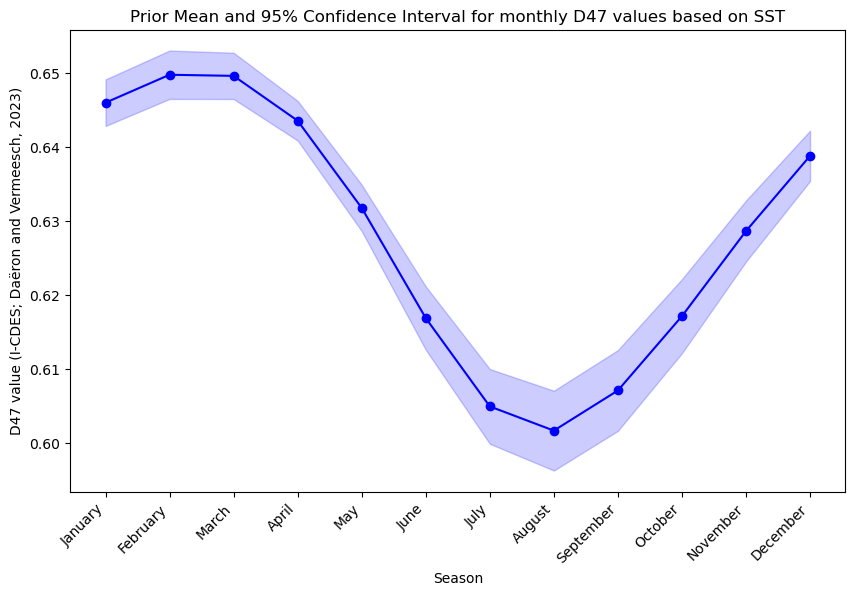

In [7]:
# Establish prior distribution based on monthly PlioMIP model outcomes

# Set dimensions of data
n_models_monthly = len(PlioMIP["modelname"]) # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot monthly prior distribution
# Plotting the prior mean and uncertainty
months_scale = np.arange(len(months)) + 1 # Create monthly scale

plt.figure(figsize = (10, 6))
plt.plot(months_scale, mu_prior_D47_monthly, label = 'Prior D47 Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for monthly D47 values based on SST')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.show() # Show plot

## Calculate the monthly prior for model SST and SAT values

In [8]:
# Prior SST & SAT estimates from climate models (mean)
mu_prior_SAT_monthly = np.array(PlioMIP[[f"{month}_SAT" for month in months]].mean(axis = 0, skipna = True))
mu_prior_SST_monthly = np.array(PlioMIP[[f"{month}_SST" for month in months]].mean(axis = 0, skipna = True))

# Covariance between months in prior SST & SAT estimates from climate models (covariance matrix)
cov_prior_SAT_monthly = np.cov(PlioMIP[[f"{month}_SAT" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_monthly = np.cov(PlioMIP[[f"{month}_SST" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_monthly_original, cov_prior_SAT_monthly_original = mu_prior_SAT_monthly.copy(), cov_prior_SAT_monthly.copy()
mu_prior_SST_monthly_original, cov_prior_SST_monthly_original = mu_prior_SST_monthly.copy(), cov_prior_SST_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))
std_prior_SST_monthly = np.sqrt(np.diag(cov_prior_SST_monthly))

print(mu_prior_SAT_monthly)
print(std_prior_SAT_monthly)

[ 6.71411765  6.69294118  8.04647059 10.80058824 14.58529412 19.27941176
 22.28411765 21.87705882 18.43058824 14.13235294 10.31941176  7.91294118]
[2.19619574 2.33777342 2.13652153 1.88298457 1.96586214 2.24523793
 2.7378734  2.89253514 2.75413206 2.61063098 2.36348384 2.20706469]


## Plot the monthly prior for model SST and SAT values

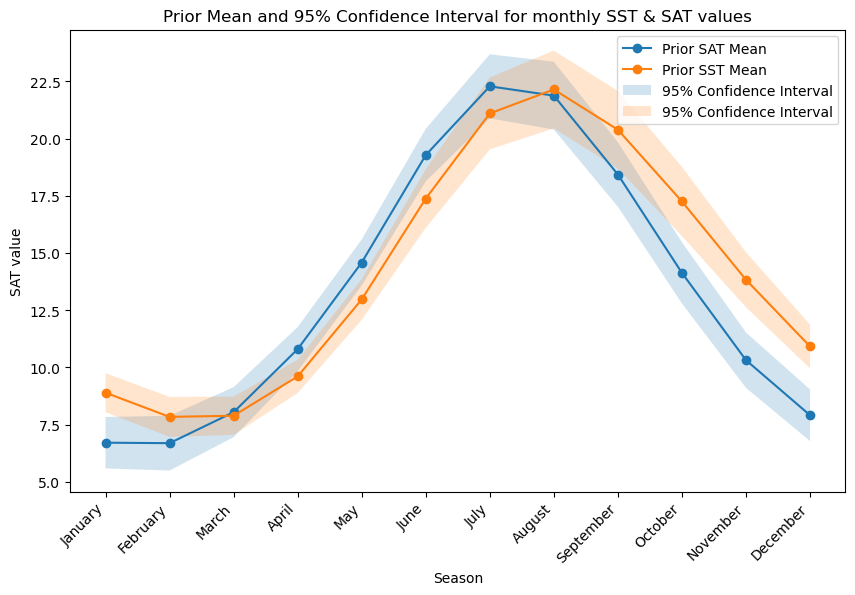

In [9]:
# Plot the prior distribution and confidence envelopes per season for SST & SAT
plt.figure(figsize=(10, 6))

# Plot the prior mean for SST & SAT
plt.plot(months_scale, mu_prior_SAT_monthly, label = 'Prior SAT Mean', marker = 'o')
plt.plot(months_scale, mu_prior_SST_monthly, label = 'Prior SST Mean', marker = 'o')

# Add 95% confidence intervals (mean ± t_inv * standard deviation)
plt.fill_between(months_scale,
                 mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                 mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                 alpha = 0.2,
                 label = '95% Confidence Interval')
plt.fill_between(months_scale,
                 mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                 mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                 alpha = 0.2,
                 label = '95% Confidence Interval')

# Update the x-axis with season names
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Prior Mean and 95% Confidence Interval for monthly SST & SAT values')
plt.xlabel('Season')
plt.ylabel('SAT value')
plt.legend()
plt.show()

## Calculate the monthly covariance matrix for D47 and SAT values

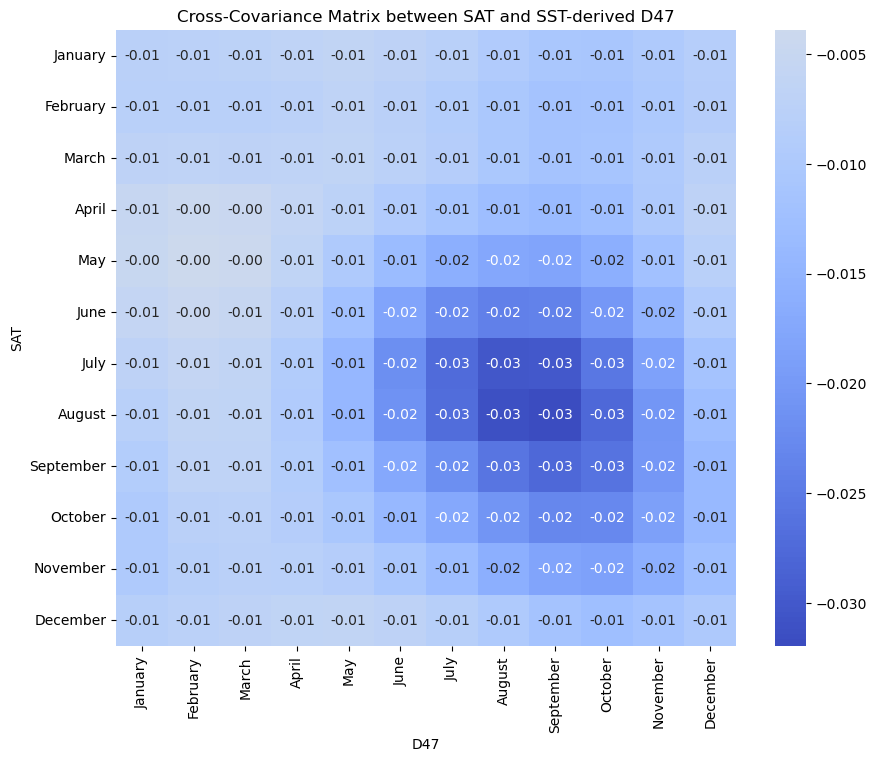

In [11]:
# Extract the relevant columns for SAT, SST, and D47
SAT_columns_monthly = [f"{month}_SAT" for month in months]
D47_columns_monthly = [f"{month}_D47" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = PlioMIP[SAT_columns_monthly + D47_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar = False)

# Extract the covariance matrices for SAT, SST, and D47
cov_SAT_monthly = cov_combined_monthly[:len(months), :len(months)]
cov_D47_monthly = cov_combined_monthly[len(months):, len(months):]

# Extract the cross-covariance matrix
cross_cov_SAT_D47_monthly = cov_combined_monthly[:len(months), len(months):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cross_cov_SAT_D47_monthly,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names,
    yticklabels = month_names
)
plt.title("Cross-Covariance Matrix between SAT and SST-derived D47")
plt.xlabel("D47")
plt.ylabel("SAT")
plt.show()

## Create combined monthly state vector

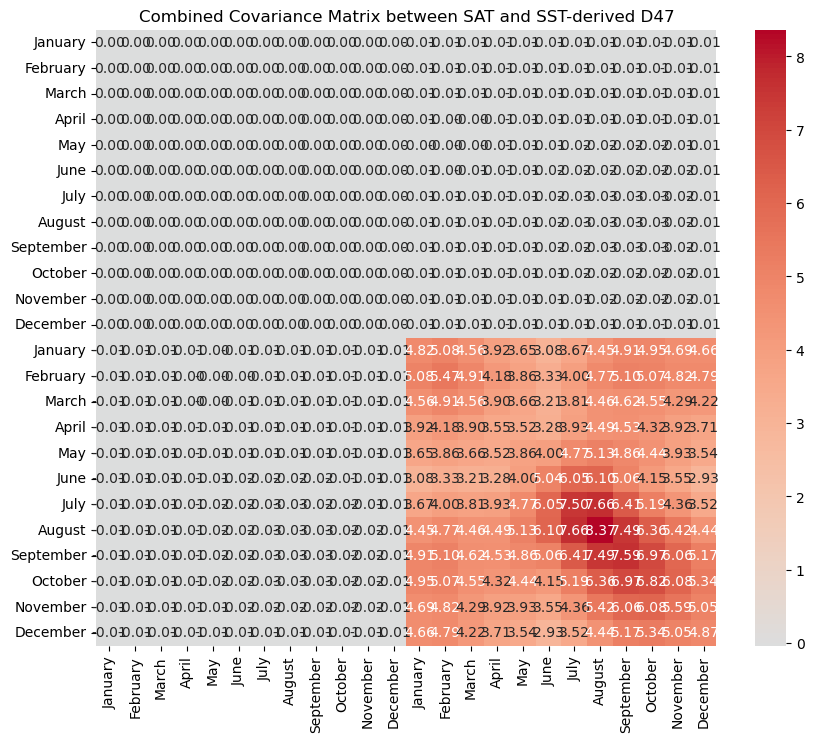

In [28]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_monthly_combined = np.concatenate((mu_prior_D47_monthly, mu_prior_SAT_monthly))

# Combine the covariance matrices of D47 and SAT, including the cross-covariance
cov_prior_monthly_combined = np.block([
    [cov_prior_D47_monthly, cross_cov_SAT_D47_monthly],
    [cross_cov_SAT_D47_monthly.T, cov_prior_SAT_monthly]
])

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cov_prior_monthly_combined,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names + month_names,
    yticklabels = month_names + month_names
)
plt.title("Combined Covariance Matrix between SAT and SST-derived D47")
plt.show()

# PRIOR - SEASONAL

## Seasonal model data (convert the PlioMIP data to seasonal means)

In [20]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create a seasonal dataframes
# Initialize dictionaries to store seasonal data
PlioMIP_seasonal_dict = {}

# Identify the columns to process (all except the modelname column)
columns_to_process = [col for col in PlioMIP.columns if any(suffix in col for suffix in ['_SST', '_SAT', '_D47', '_D47_SE'])]

# Process each season
for season, months in seasons.items(): # Iterate over the seasons and corresponding months
    for col in columns_to_process: # Iterate over the columns to process
        base_col_name = col.split('_')[0] # Extract the base column name
        suffix = '_'.join(col.split('_')[1:]) # Extract the suffix
        if base_col_name in months: # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}" # Create the new column name
            if season_col_name not in PlioMIP_seasonal_dict: # Check if the new column name already exists in the seasonal data
                PlioMIP_seasonal_dict[season_col_name] = [] # If not, tnitialize a new column in the seasonal data means
            PlioMIP_seasonal_dict[season_col_name].append(PlioMIP[col])

# Combine the seasonal data into a single dataframe
PlioMIP_seasonal = pd.DataFrame()
for season_col_name, data in PlioMIP_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis = 0).reset_index(drop = True)
    PlioMIP_seasonal[season_col_name] = concatenated_data

# Add model names
PlioMIP_seasonal["modelname"] = np.tile(PlioMIP["modelname"].values, 3) # Repeat the model names for each season

# Display the new seasonal DataFrame
D47_columns_seasonal = [col for col in PlioMIP_seasonal.columns if col.endswith('_D47')]
D47_se_columns_seasonal = [col for col in PlioMIP_seasonal.columns if '_D47_SE' in col]
# PlioMIP_seasonal.head()
print("Seasonal D47 values for all SST model outcomes:\n", PlioMIP_seasonal[D47_columns_seasonal].head())
print("Calibration standard errors for all SST model outcomes:\n", PlioMIP_seasonal[D47_se_columns_seasonal].head())

Seasonal D47 values for all SST model outcomes:
    winter_D47  spring_D47  summer_D47  autumn_D47
0         NaN         NaN         NaN         NaN
1    0.648316    0.651496    0.613992    0.600724
2    0.642505    0.646093    0.610876    0.596581
3         NaN         NaN         NaN         NaN
4         NaN         NaN         NaN         NaN
Calibration standard errors for all SST model outcomes:
    winter_D47_SE  spring_D47_SE  summer_D47_SE  autumn_D47_SE
0            NaN            NaN            NaN            NaN
1       0.001328       0.001353       0.001119       0.001072
2       0.001284       0.001311       0.001106       0.001062
3            NaN            NaN            NaN            NaN
4            NaN            NaN            NaN            NaN


## Calculate the seasonal prior for model SST-derived D47 values with propagated uncertainty

In [21]:
# Define the seasons
seasons = ["winter", "spring", "summer", "autumn"]

# Set the weights of the data based on the standard errors
weights_seasonal = 1 / PlioMIP_seasonal[[f"{season}_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal.columns = [col.replace('_D47_SE', '_D47') for col in weights_seasonal.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_D47_seasonal = np.array((PlioMIP_seasonal[[f"{season}_D47" for season in seasons]] * weights_seasonal).sum(axis = 0, skipna = True) / weights_seasonal.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array

# Decompose variance within and between model outcomes
model_variances = PlioMIP_seasonal[[f"{season}_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances = (PlioMIP_seasonal[[f"{season}_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal = np.cov(PlioMIP_seasonal[[f"{season}_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_D47_seasonal = cov_raw_seasonal.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_D47_seasonal, np.diagonal(cov_raw_seasonal) + measurement_variances)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_D47_seasonal_original, cov_prior_D47_seasonal_original = mu_prior_D47_seasonal.copy(), cov_prior_D47_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_D47_seasonal = np.sqrt(np.diag(cov_prior_D47_seasonal))

print(mu_prior_D47_seasonal)
print(std_prior_D47_seasonal)

[0.64458794 0.64100872 0.60755872 0.61700536]
[0.00772363 0.00941372 0.01142462 0.01282204]


## Plot the seasonal prior for model SST-derived D47 values with propagated uncertainty

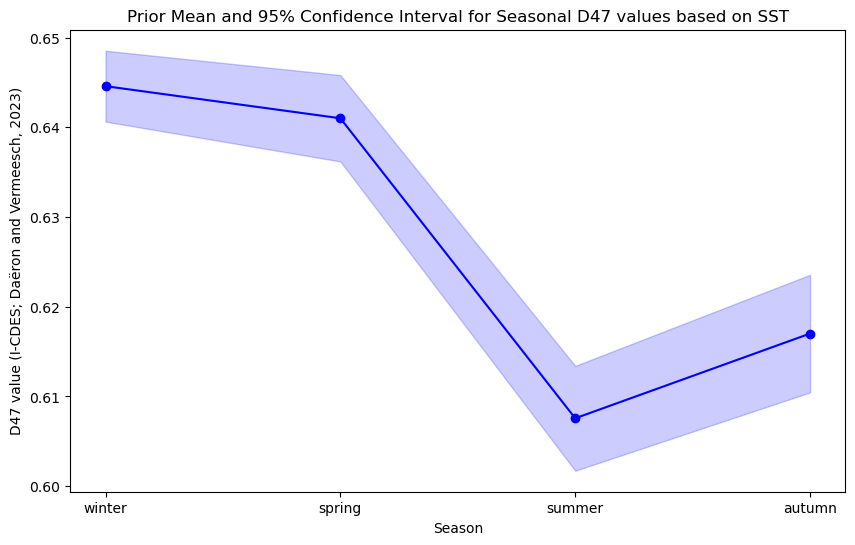

In [22]:
# Establish prior distribution based on seasonal PlioMIP model outcomes

# Set dimensions of data
n_models_seasonal = len(PlioMIP["modelname"]) # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)

# Plot seasonal prior distribution
# Plotting the prior mean and uncertainty
seasons_scale = np.arange(len(seasons)) + 1 # Create seasonal scale

plt.figure(figsize = (10, 6))
plt.plot(seasons_scale, mu_prior_D47_seasonal, label = 'Prior D47 Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for Seasonal D47 values based on SST')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(seasons_scale, seasons)
plt.show() # Show plot

## Calculate the seasonal prior for model SST and SAT values

In [23]:
# Prior SST & SAT estimates from climate models (mean)
mu_prior_SAT_seasonal = np.array(PlioMIP_seasonal[[f"{season}_SAT" for season in seasons]].mean(axis = 0, skipna = True))
mu_prior_SST_seasonal = np.array(PlioMIP_seasonal[[f"{season}_SST" for season in seasons]].mean(axis = 0, skipna = True))

# Covariance between seasons in prior SST & SAT estimates from climate models (covariance matrix)
cov_prior_SAT_seasonal = np.cov(PlioMIP_seasonal[[f"{season}_SAT" for season in seasons]].dropna(), rowvar=False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_seasonal = np.cov(PlioMIP_seasonal[[f"{season}_SST" for season in seasons]].dropna(), rowvar=False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_seasonal_original, cov_prior_SAT_seasonal_original = mu_prior_SAT_seasonal.copy(), cov_prior_SAT_seasonal.copy()
mu_prior_SST_seasonal_original, cov_prior_SST_seasonal_original = mu_prior_SST_seasonal.copy(), cov_prior_SST_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))
std_prior_SST_seasonal = np.sqrt(np.diag(cov_prior_SST_seasonal))

print(mu_prior_SAT_seasonal)
print(std_prior_SAT_seasonal)

[ 7.10666667 11.14411765 21.14686275 14.29411765]
[2.27655149 3.34076828 2.9147806  4.19447121]


## Plot the seasonal prior for model SAT values

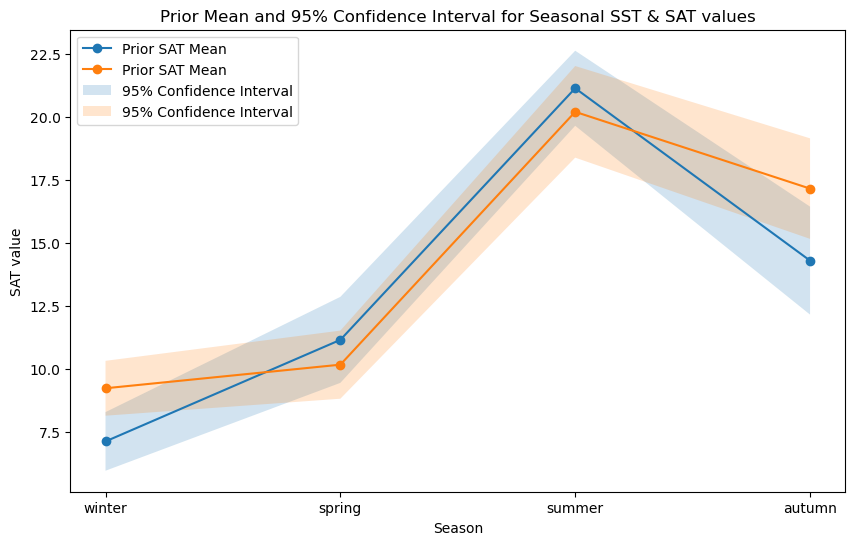

In [24]:
# Plot the prior distribution and confidence envelopes per season for SST & SAT
plt.figure(figsize=(10, 6))

# Plot the prior mean for SST & SAT
plt.plot(seasons_scale, mu_prior_SAT_seasonal, label = 'Prior SAT Mean', marker = 'o')
plt.plot(seasons_scale, mu_prior_SST_seasonal, label = 'Prior SAT Mean', marker = 'o')

# Add 95% confidence intervals (mean ± t_inv * standard deviation)
plt.fill_between(seasons_scale,
                 mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                 mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                 alpha = 0.2,
                 label = '95% Confidence Interval')
plt.fill_between(seasons_scale,
                 mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                 mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                 alpha = 0.2,
                 label = '95% Confidence Interval')

# Update the x-axis with season names
plt.xticks(seasons_scale, seasons)
plt.title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
plt.xlabel('Season')
plt.ylabel('SAT value')
plt.legend()
plt.show()

## Calculate the seasonal covariance matrix for D47 and SAT values

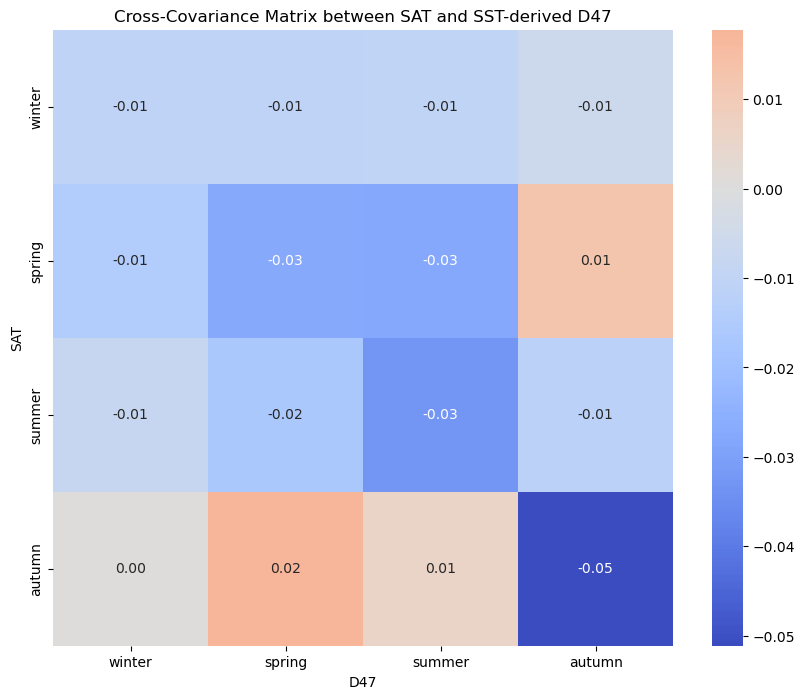

In [26]:
# Extract the relevant columns for SAT, SST, and D47
sat_columns_seasonal = [f"{season}_SAT" for season in seasons]
d47_columns_seasonal = [f"{season}_D47" for season in seasons]

# Combine the relevant columns into a single dataframe
combined_data_seasonal = PlioMIP_seasonal[sat_columns_seasonal + d47_columns_seasonal]

# Calculate the covariance matrix for the combined data
cov_combined_seasonal = np.cov(combined_data_seasonal.dropna(), rowvar = False)

# Extract the covariance matrices for SAT, SST, and D47
cov_SAT_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_D47_seasonal = cov_combined_seasonal[len(seasons):, len(seasons):]

# Extract the cross-covariance matrix
cross_cov_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cross_cov_SAT_D47_seasonal,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons,
    yticklabels = seasons
)
plt.title("Cross-Covariance Matrix between SAT and SST-derived D47")
plt.xlabel("D47")
plt.ylabel("SAT")
plt.show()

## Create combined seasonal state vector

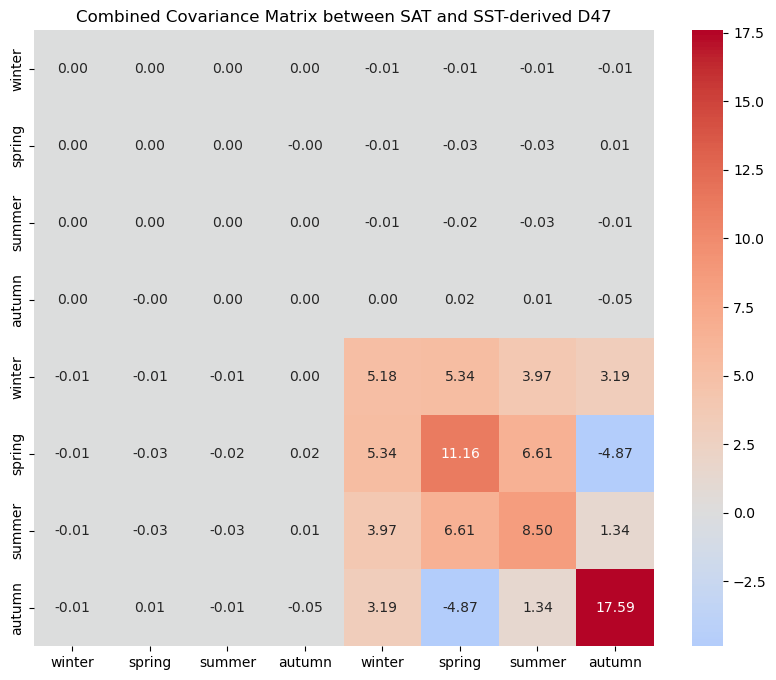

In [29]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_seasonal_combined = np.concatenate((mu_prior_D47_seasonal, mu_prior_SAT_seasonal))

# Combine the covariance matrices of D47 and SAT, including the cross-covariance
cov_prior_seasonal_combined = np.block([
    [cov_prior_D47_seasonal, cross_cov_SAT_D47_seasonal],
    [cross_cov_SAT_D47_seasonal.T, cov_prior_SAT_seasonal]
])

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cov_prior_seasonal_combined,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons + seasons,
    yticklabels = seasons + seasons
)
plt.title("Combined Covariance Matrix between SAT and SST-derived D47")
plt.show()

# OBSERVATIONS
## Load clumped data for updating
### Seasonal data from PWP paper

In [30]:
# Load seasonal measurements and format them into a dictionary
# This is precompiled seasonal data per specimen and therefore does not come with a time uncertainty
PWP_D47_seasonal = pd.read_csv('PWP case/PWP_proxy_data_seasonal.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_seasonal_dict = PWP_D47_seasonal.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because data is already aggregated seasonally)
for record in PWP_D47_seasonal_dict:
    record["Season_err"] = 0

# print(PWP_D47_seasonal_dict[0]) # Print to check the structure of the data

### Monthly and seasonal data calculated from ShellChron outcomes

In [31]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
PWP_D47 = pd.read_csv('PWP case/PWP_proxy_data_months.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_dict = PWP_D47.to_dict('records') # Convert to dictionary with column headers as keys

# Process the ShellChron_DOY_err field and create a new entry for months
for record in PWP_D47_dict:
    # Handle missing values and convert from days to months and seasons
    shell_chron_doy_err = record.get("ShellChron_DOY_err", np.nan)  # Get value, default to NaN if missing
    if pd.isna(shell_chron_doy_err):  # Check if the value is NaN
        record["ShellChron_Month_err"] = 0  # Set the new entry to 0 if missing
        record["ShellChron_Season_err"] = 0  # Set the new entry to 0 if missing
    else:
        record["ShellChron_Month_err"] = shell_chron_doy_err / 365 * 12  # Convert days to months
        record["ShellChron_Season_err"] = shell_chron_doy_err / 365 * 4  # Convert days to seasons
    
    # Add the month_score2 and season_score field based on the ShellChron_DOY field
    ShellChron_DOY = record.get("ShellChron_DOY_rotated", np.nan)  # Get the ShellChron day of the year value
    if not pd.isna(ShellChron_DOY):  # Check if the ShellChron value is not NaN
        record["month_score2"] = ShellChron_DOY / 365 * 12  # Convert DOY value to month_score
        record["season_score"] = ShellChron_DOY / 365 * 4  # Convert DOY value to season_score

# print(PWP_D47_dict[0]) # Print to check the structure of the data

## Prepare measurement and observation matrices (no ShellChron time uncertainty implemented yet)

### Measurement matrix for season-averaged D47 values

In [37]:
# Extract measurements and uncertainties from the dictionary
measurements_seasonal = [measurement["D47"] for measurement in PWP_D47_seasonal_dict] # Extract the D47 values
measurement_uncertainties_seasonal = [measurement["D47_sd"] ** 2 for measurement in PWP_D47_seasonal_dict] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_seasonal_averaged = np.array(measurements_seasonal).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_seasonal_averaged = np.diag(measurement_uncertainties_seasonal)

# Number of seasonally averaged measurements
N_measurements_seasonal = len(measurements_seasonal)

## Observation matrix for season-averaged D47 data

In [42]:
# Create the observation matrix H for monthly data based on individual measurements
H_seasonal_averaged = np.zeros((N_measurements_seasonal, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(PWP_D47_seasonal_dict):
    time_index = int(measurement["season"])
    H_seasonal_averaged[i, time_index] = 1

print(H_seasonal_averaged)

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


### Measurement matrix for individual D47 values

In [39]:
# Extract measurements and uncertainties from the dictionary
measurements = [measurement["D47_corrETF_strict"] for measurement in PWP_D47_dict] # Extract the D47 values
measurement_uncertainties = [measurement["D47_sd_ext"] ** 2 for measurement in PWP_D47_dict] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_monthly = np.array(measurements).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_monthly = np.diag(measurement_uncertainties)

# Number of measurements
N_measurements = len(measurements)

## Observation matrix for seasonal D47 data from individual D47 values

In [44]:
# Create the observation matrix H for monthly data based on individual measurements
H_seasonal = np.zeros((N_measurements, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(PWP_D47_dict):
    time_index = int(measurement["season_score"])
    H_seasonal[i, time_index] = 1

print(H_seasonal)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## Observation matrix for monthly D47 data

In [43]:
# Create the observation matrix H for monthly data based on individual measurements
H_monthly = np.zeros((N_measurements, len(mu_prior_monthly_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(PWP_D47_dict):
    time_index = int(measurement["month_score2"])
    H_monthly[i, time_index] = 1

print(H_monthly)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# UPDATE

## Create updating function (Kalman filter)
- Include updating of second variable (SAT) through cross-covariance
- Use block updating

## Copy of old Kalman function (point-by-point updating)

In [ ]:
# Create Kalman updating function
def kalman_update_old(
    mu_prior,
    cov_prior,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "D47",
    Variable_name_SD = "D47_sd",
    cross_cov = None,
    mu_prior_SAT = None,
    cov_prior_SAT = None
):
    """
Update the prior state with a measurement, including uncertainty in the time domain.

Parameters:
- mu_prior: np.ndarray
    Prior means for all bins for the measured variable (usually D47).
- cov_prior: np.ndarray
    Covariance matrix for the prior state of the measured variable (usually D47).
- measurement: dict
    Dictionary containing the observation, its SD, and a timestamp value with its SD.
- timestamp: str
    Key in the measurement dictionary for the timestamp (0-based index).
- timestamp_sd: float
    Standard deviation of uncertainty in the timestamp (in units of timestamp).
- Variable_name: str
    Key in the measurement dictionary for the data.
- Variable_name_SD: str
    Key in the measurement dictionary for the standard deviation on the data.
- cross_cov: np.ndarray, optional
    Cross-covariance matrix between the measured variable (D47) and a second (unmeasured) variable (SAT).
- mu_prior_SAT: np.ndarray, optional
    Prior means for a second (unmeasured) variable (SAT).
- cov_prior_SAT: np.ndarray, optional
    Covariance matrix for a second (unmeasured) variable (SAT).

Returns:
- mu_prior: np.ndarray
    Updated means after applying the measurement.
- cov_prior: np.ndarray
    Updated covariance matrix after applying the measurement.
- mu_prior_SAT: np.ndarray, optional
    Updated means for SAT after applying the measurement.
- cov_prior_SAT: np.ndarray, optional
    Updated covariance matrix for SAT after applying the measurement.
"""
    try: # Catch errors in individual entries without breaking the loop
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        obs_variable = measurement[Variable_name]
        obs_var = measurement[Variable_name_SD] ** 2

        if not np.isnan(time) and not np.isnan(obs_variable) and not np.isnan(obs_var): # Check if the observation is not NaN
            if time_sd == 0 or np.isnan(time_sd): # If there is no uncertainty in the timestamp
                # Direct update without using weights (standard Kalman update)

                # Prior mean and variance for the specific time
                mu_prior_time = mu_prior[int(time)]
                cov_prior_time = cov_prior[int(time), int(time)]
                
                # Kalman gain
                K = cov_prior_time / (cov_prior_time + obs_var)

                # Update mean and variance
                mu_post_time = mu_prior_time + K * (obs_variable - mu_prior_time)
                cov_post_time = (1 - K) * cov_prior_time
                
                # Update the prior arrays with the new posterior values to create posteriors
                mu_post = mu_prior.copy()
                cov_post = cov_prior.copy()
                mu_post[int(time)] = mu_post_time
                cov_post[int(time), int(time)] = cov_post_time

                # Check if cross-covariance and SAT estimates are provided
                if cross_cov is not None and mu_prior_SAT is not None and cov_prior_SAT is not None:
                    # print(mu_prior_SAT) # Print the updated SAT estimates to check
                    # print(np.diag(cov_prior_SAT)) # Print the updated SAT covariance matrix to check
                    # Update SAT estimates using cross-covariance
                    cross_cov_time = cross_cov[int(time), :] # Extract the cross-covariance for the given time unit
                    K_SAT = cross_cov_time / (cov_prior_time + obs_var) # Calculate the Kalman gain for the second variable (SAT)
                    mu_post_SAT = mu_prior_SAT + K_SAT * (obs_variable - mu_prior_time) # Update the mean for the second variable (SAT)
                    cov_post_SAT = cov_prior_SAT - np.outer(K_SAT, cross_cov_time) # Update the covariance for the second variable (SAT)

                    return mu_post, cov_post, mu_post_SAT, cov_post_SAT # Return updated values for both variables
                                
            else: # If there is uncertainty in the timestamp
                # Define possible bins and weights based on normal uncertainty on the age of the measurement
                n_bins = len(mu_prior)
                time_indices = np.arange(n_bins)
                weights = stats.norm.pdf(time_indices, loc = time, scale = time_sd)
                weights = weights / weights.sum()  # Normalize weights

                # Weighted observation and variance
                weighted_obs = np.sum(weights * mu_prior) # calculate the weighted prior mean
                weighted_var = obs_var + np.sum(weights ** 2 * np.diag(cov_prior)) # calculate a weighted variance with respect to the uncertainty distribution of the time of the measurement

                # Kalman gain weighted by the uncertainty on the age determination
                K = np.dot(cov_prior, weights) / (np.dot(weights, np.dot(cov_prior, weights)) + weighted_var)

                # Update mean values
                mu_post = mu_prior + K * (obs_variable - weighted_obs)

                # Update covariance matrix

                ## FIXME: Sometimes results in negative variance, which is not possible!!
                ## Potential solution: Overwrite diagonal elements with the weighted variances?

                # # Update covariance matrix using Joseph form to ensure positive semi-definite matrix
                # I = np.eye(n_bins) # Identity matrix
                # KH = np.outer(K, weights) # Product of Kalman gain and weights
                # cov_post = np.dot(np.dot((I - KH), cov_prior), (I - KH).T) + np.outer(K, K) * weighted_var
                
                cov_post = cov_prior - np.outer(K, np.dot(weights, cov_prior)) # Simplified form without Joseph form

                # Check if cross-covariance and SAT estimates are provided
                if cross_cov is not None and mu_prior_SAT is not None and cov_prior_SAT is not None:
                    # print(mu_prior_SAT) # Print the updated SAT estimates to check
                    # print(np.diag(cov_prior_SAT)) # Print the updated SAT covariance matrix to check
                    # Update SAT estimates using cross-covariance
                    cross_cov_weighted = np.dot(cross_cov, weights) # Calculate the weighted cross-covariance between the two variables
                    K_SAT = cross_cov_weighted / (np.dot(weights, np.dot(cov_prior, weights)) + weighted_var) # Calculate the Kalman gain for the second variable (SAT) by dividing the weighted cross-covariance by the weighted variance on the measured variable
                    mu_post_SAT = mu_prior_SAT + K_SAT * (obs_variable - weighted_obs) # Update the mean for the second variable (SAT)
                    cov_post_SAT = cov_prior_SAT - np.outer(K_SAT, cross_cov_weighted) # Update the covariance for the second variable (SAT)

                    return mu_post, cov_post, mu_post_SAT, cov_post_SAT
                
            return mu_post, cov_post # Return updated values for the measured variable only
        
        else: # If observation is NaN
            if cross_cov is not None and mu_prior_SAT is not None and cov_prior_SAT is not None: # Check if cross-covariance and SAT estimates are provided
                return mu_prior, cov_prior, mu_prior_SAT, cov_prior_SAT # Return unmodified values for both variables
            else: # If cross-covariance and SAT estimates are not provided
                return mu_prior, cov_prior  # Return unmodified values  
        
    except (KeyError, TypeError, ValueError) as e: # Return errors if they occur
        print(f"Error in kalman_update: {e}")
        if cross_cov is not None and mu_prior_SAT is not None and cov_prior_SAT is not None: # Check if cross-covariance and SAT estimates are provided
            return mu_prior, cov_prior, mu_prior_SAT, cov_prior_SAT  # Return the unmodified values for both variables even on error
        else: # If cross-covariance and SAT estimates are not provided
            return mu_prior, cov_prior  # Return the unmodified values even on error to prevent errors during the looping later

## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [ ]:
# Create function to keep track of the likelihood statistics and data

# Suppress FutureWarning
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def likelihood_statistics(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "Variable_name",
    Variable_name_SD = "Variable_name_SD"
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin.
    - n_update: list
        List tracking the number of datapoints for each time bin.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing seasonal and temperature data.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: str
        Key in the measurement dictionary for the time bin (e.g. month or season).
    - Variable_name_SD: str
        Key in the measurement dictionary for the standard deviation on the age model (e.g. month or season).
    """
    if timestamp in measurement and Variable_name in measurement and Variable_name_SD in measurement:
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        data_val = measurement[Variable_name]
        data_sd = measurement[Variable_name_SD]
        
        # print(time, time_sd, data_val, data_sd) # Print to check the values

        # Check if the data is valid
        if not np.isnan(data_val) and not np.isnan(data_sd):
            # Calculate the weight (inverse of variance)
            weight = 1 / (data_sd ** 2)
                        
            # Determine the number of bins
            num_bins = len(weighted_sum)
            bin_indices = np.arange(num_bins, dtype = np.float64)
            
            # Calculate the probability density for each bin
            if time_sd == 0: # Catch cases where the time uncertainty is zero (or unknown)
                probabilities = np.zeros(num_bins, dtype = np.float64)
                bin_index = int(time) % num_bins  # Ensure the bin index is within range
                probabilities[bin_index] = 1 # Set the probability to 1 for the correct bin
            else:
                probabilities = stats.norm.pdf(bin_indices, loc = time, scale = time_sd) # For non-zero time uncertainty, use a normal distribution
                probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1
            
            for i, prob in enumerate(probabilities): # Loop over all possible bin numbers in the probability vector
                bin_index = i % num_bins  # Wrap around to the first bin if it overflows
                
                # Update the weighted sums and sample count
                effective_weight = weight * prob
                if weighted_sum[bin_index] is None:
                    weighted_sum[bin_index] = 0
                    effective_weights_total[bin_index] = 0
                weighted_sum[bin_index] = weighted_sum[bin_index] + data_val * effective_weight
                effective_weights_total[bin_index] = effective_weights_total[bin_index] + effective_weight
            
            n_update[int(time) % num_bins] = n_update[int(time) % num_bins] + 1 # update sample number per bin

            # Track individual data points and their uncertainties
            if time not in data_library:
                data_library[int(time)] = []  # Initialize the list for a new time bin
            data_library[int(time)].append((time_sd, data_val, data_sd))
    
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

## EXECUTE UPDATING FUNCTIONS

## Update seasonal prior with data
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen

### Calculate D47 posteriors when using cross-covariance with SAT

In [ ]:
# FIXME: This function is not working as intended and needs to be debugged
# Apply new function to update the prior with seasonal data including updating the SAT estimates
# Update the seasonal D47 and SAT prior with all measurements
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Reset the prior to the original values
mu_prior_D47_seasonal, cov_prior_D47_seasonal, mu_prior_SAT_seasonal, cov_prior_SAT_seasonal = mu_prior_D47_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy(), mu_prior_SAT_seasonal_original.copy(), cov_prior_SAT_seasonal_original.copy()

for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    # print(measurement) # Print to check the values
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_seasonal, cov_prior_D47_seasonal, mu_prior_SAT_seasonal, cov_prior_SAT_seasonal = kalman_update(
        mu_prior_D47_seasonal,
        cov_prior_D47_seasonal,
        measurement,
        timestamp = "season",
        timestamp_sd = "Season_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_sd",
        cross_cov = cross_cov_SAT_D47_seasonal,
        mu_prior_SAT = mu_prior_SAT_seasonal,
        cov_prior_SAT = cov_prior_SAT_seasonal
    )
    
    # Track and update likelihood statistics
    weighted_sum_seasonal, effective_weights_total_seasonal, n_update_seasonal, seasonal_data = likelihood_statistics(
        weighted_sum_seasonal,
        effective_weights_total_seasonal,
        n_update_seasonal,
        seasonal_data,
        measurement,
        timestamp = "season",
        timestamp_sd = "Season_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_sd"
    )

# Normalize the weighted_sum_seasonal to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal)):
    if effective_weights_total_seasonal[i] is not None and effective_weights_total_seasonal[i] != 0:
        mu_likelihood_seasonal[i] = weighted_sum_seasonal[i] / effective_weights_total_seasonal[i]
        std_likelihood_seasonal[i] = np.sqrt(1 / effective_weights_total_seasonal[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal[i]}")
    print(f"Number of Data Points: {n_update_seasonal[i]}\n")

# Print original and updated prior means and uncertainties
# print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original)
# print("Updated Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal)
# print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)))
# print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_seasonal)))
# print("Original Prior Mean SAT Seasonal:\n", mu_prior_SAT_seasonal_original)
# print("Updated Prior Mean SAT Seasonal:\n", mu_prior_SAT_seasonal)
# print("Original Prior Standard Deviation SAT Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_seasonal_original)))
# print("Updated Prior Variance SAT Seasonal:\n", (np.diag(cov_prior_SAT_seasonal)))

print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original)
print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)))
print("Updated Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal)
print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal)))
print("Original Prior Mean SAT Seasonal:\n", mu_prior_SAT_seasonal_original)
print("Original Prior Standard Deviation SAT Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_seasonal_original)))
print("Updated Prior Mean SAT Seasonal:\n", mu_prior_SAT_seasonal)
print("Updated Prior Standard Deviation SAT Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_seasonal)))

### Plot seasonal posterior in D47 domain

In [ ]:
# Plot the updated seasonal posterior
std_post_D47_seasonal = np.sqrt(np.diag(cov_prior_D47_seasonal))
std_prior_D47_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"] + 1, measurement["D47"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"] + 1, measurement["D47"], yerr = measurement["D47_sd"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_D47_seasonal,
    mu_prior_D47_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_D47_seasonal,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with data based on ShellChron
* Aggregate data and model outcomes in 4 seasons based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [ ]:
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data = {} # Keep track of datapoints per season
n_update_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Restore original seasonal prior means and covariance matrix
mu_prior_D47_seasonalSC, cov_prior_D47_seasonalSC, mu_prior_SAT_seasonalSC, cov_prior_SAT_seasonalSC = mu_prior_D47_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy(), mu_prior_SAT_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    # print(measurement["season_score"])
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_seasonalSC, cov_prior_D47_seasonalSC, mu_prior_SAT_seasonalSC, cov_prior_SAT_seasonalSC = kalman_update(
        mu_prior_D47_seasonalSC,
        cov_prior_D47_seasonalSC,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext",
        cross_cov = cov_SAT_D47_seasonal,
        mu_prior_SAT = mu_prior_SAT_seasonalSC,
        cov_prior_SAT = cov_prior_SAT_seasonalSC
    )
    
    # Track and update likelihood statistics
    weighted_sum_seasonalSC, effective_weights_total_seasonalSC, n_update_seasonalSC, seasonalSC_data = likelihood_statistics(
        weighted_sum_seasonalSC,
        effective_weights_total_seasonalSC,
        n_update_seasonalSC,
        seasonalSC_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC)):
    if effective_weights_total_seasonalSC[i] is not None and effective_weights_total_seasonalSC[i] != 0:
        mu_likelihood_seasonalSC[i] = weighted_sum_seasonalSC[i] / effective_weights_total_seasonalSC[i]
        std_likelihood_seasonalSC[i] = np.sqrt(1 / effective_weights_total_seasonalSC[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC[i]}\n")

### Plot seasonal posterior in D47 domain based on ShellChron dating

In [ ]:
# Plot the updated seasonal posterior
std_post_D47_seasonalSC = np.sqrt(np.diag(cov_prior_D47_seasonalSC))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_D47_seasonalSC, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonalSC - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_D47_seasonalSC,
    mu_prior_D47_seasonalSC + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_D47_seasonalSC,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)
print(cov_prior_D47_seasonalSC)
print(cov_prior_D47_seasonal_original)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

### DEBUGGING: First check the outcome in D47 posterior using the old function

In [ ]:
# FIXME: Results in negative variance for winter, which is not possible!! (and does not occur in the SAT cross-covariance example)
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data_old = {} # Keep track of datapoints per season
n_update_seasonalSC_old = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC_old = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC_old = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC_old = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC_old = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Restore original seasonal prior means and covariance matrix
mu_prior_D47_seasonalSC_old, cov_prior_D47_seasonalSC_old = mu_prior_D47_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_seasonalSC_old, cov_prior_D47_seasonalSC_old = kalman_update_old(
        mu_prior_D47_seasonalSC_old,
        cov_prior_D47_seasonalSC_old,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )
    # print(np.diag(cov_prior_D47_seasonalSC_old))
    
    # Track and update likelihood statistics
    weighted_sum_seasonalSC_old, effective_weights_total_seasonalSC_old, n_update_seasonalSC_old, seasonalSC_data_old = likelihood_statistics(
        weighted_sum_seasonalSC_old,
        effective_weights_total_seasonalSC_old,
        n_update_seasonalSC_old,
        seasonalSC_data_old,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC_old to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC_old to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC_old)):
    if effective_weights_total_seasonalSC_old[i] is not None and effective_weights_total_seasonalSC_old[i] != 0:
        mu_likelihood_seasonalSC_old[i] = weighted_sum_seasonalSC_old[i] / effective_weights_total_seasonalSC_old[i]
        std_likelihood_seasonalSC_old[i] = np.sqrt(1 / effective_weights_total_seasonalSC_old[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC_old[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC_old[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC_old[i]}\n")

### DEBUGGING: Plot seasonal posterior in D47 domain based on ShellChron dating and using old Kalman function

In [ ]:
# Plot the updated seasonal posterior
std_post_D47_seasonalSC_old = np.sqrt(np.diag(cov_prior_D47_seasonalSC_old))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_old, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_old - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_old / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC_old + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_old / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_D47_seasonalSC_old, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonalSC_old - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_D47_seasonalSC_old,
    mu_prior_D47_seasonalSC_old + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_D47_seasonalSC_old,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)
print(cov_prior_D47_seasonalSC_old)
print(cov_prior_D47_seasonal_original)
print(mu_likelihood_seasonalSC_old)
print(weighted_sum_seasonalSC_old)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with data based on ShellChron
* Aggregate data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [ ]:
## Update seasonal prior with data based on ShellChron (without sclero-dating uncertainty)
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data = {} # Keep track of datapoints per season
n_update_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC_noerr = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Restore original seasonal prior means and covariance matrix
mu_prior_D47_seasonalSC_noerr, cov_prior_D47_seasonalSC_noerr, mu_prior_SAT_seasonalSC_noerr, cov_prior_SAT_seasonalSC_noerr = mu_prior_D47_seasonal_original.copy(), cov_prior_D47_seasonal_original.copy(), mu_prior_SAT_seasonal_original.copy(), cov_prior_SAT_seasonal_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    measurement["Zero_ShellChron_Season_err"] = 0 # Set the time uncertainty to zero to eliminate uncertainty on the dating
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_seasonalSC_noerr, cov_prior_D47_seasonalSC_noerr, mu_prior_SAT_seasonalSC_noerr, cov_prior_SAT_seasonalSC_noerr = kalman_update(
        mu_prior_D47_seasonalSC_noerr,
        cov_prior_D47_seasonalSC_noerr,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Zero_ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext",
        cross_cov = cov_SAT_D47_seasonal,
        mu_prior_SAT = mu_prior_SAT_seasonalSC_noerr,
        cov_prior_SAT = cov_prior_SAT_seasonalSC_noerr
    )
    # print(np.diag(cov_prior_D47_seasonalSC_noerr))
    
    # Track and update likelihood statistics
    weighted_sum_seasonalSC_noerr, effective_weights_total_seasonalSC_noerr, n_update_seasonalSC_noerr, seasonalSC_data = likelihood_statistics(
        weighted_sum_seasonalSC_noerr,
        effective_weights_total_seasonalSC_noerr,
        n_update_seasonalSC_noerr,
        seasonalSC_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Zero_ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC_noerr)):
    if effective_weights_total_seasonalSC_noerr[i] is not None and effective_weights_total_seasonalSC_noerr[i] != 0:
        mu_likelihood_seasonalSC_noerr[i] = weighted_sum_seasonalSC_noerr[i] / effective_weights_total_seasonalSC_noerr[i]
        std_likelihood_seasonalSC_noerr[i] = np.sqrt(1 / effective_weights_total_seasonalSC_noerr[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC_noerr[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC_noerr[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC_noerr[i]}\n")

### Plot seasonal posterior in D47 domain based on ShellChron dating

In [ ]:
# Plot the updated seasonal posterior
std_post_D47_seasonalSC_noerr = np.sqrt(np.diag(cov_prior_D47_seasonalSC_noerr))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr),
    mu_likelihood_seasonalSC_noerr + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_D47_seasonalSC_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonalSC_noerr - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_D47_seasonalSC_noerr,
    mu_prior_D47_seasonalSC_noerr + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_D47_seasonalSC_noerr,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update monthly prior with data
* Data and model outcomes aggregated per month
* Including sclero-dating uncertainty
* D47 data treated as individual datapoints

In [ ]:
# Update the monthly prior with all measurements
monthly_data = {} # Keep track of datapoints per season
n_update_monthly = mu_prior_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Reset the prior to the original values
mu_prior_D47_monthly, cov_prior_D47_monthly, mu_prior_SAT_monthly, cov_prior_SAT_monthly = mu_prior_D47_monthly_original.copy(), cov_prior_D47_monthly_original.copy(), mu_prior_SAT_monthly_original.copy(), cov_prior_SAT_monthly_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_monthly, cov_prior_D47_monthly, mu_prior_SAT_monthly, cov_prior_SAT_monthly = kalman_update(
        mu_prior_D47_monthly,
        cov_prior_D47_monthly,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext",
        cross_cov = cov_SAT_D47_monthly,
        mu_prior_SAT = mu_prior_SAT_monthly,
        cov_prior_SAT = cov_prior_SAT_monthly
    )
    
    # Track and update likelihood statistics
    weighted_sum_monthly, effective_weights_total_monthly, n_update_monthly, monthly_data = likelihood_statistics(
        weighted_sum_monthly,
        effective_weights_total_monthly,
        n_update_monthly,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly)):
    if effective_weights_total_monthly[i] is not None and effective_weights_total_monthly[i] != 0:
        mu_likelihood_monthly[i] = weighted_sum_monthly[i] / effective_weights_total_monthly[i]
        std_likelihood_monthly[i] = np.sqrt(1 / effective_weights_total_monthly[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly[i]}")
    print(f"Number of Data Points: {n_update_monthly[i]}\n")

print(mu_prior_D47_monthly)

### Plot monthly posterior in D47 domain

In [ ]:
# Plot the updated posterior
std_prior_D47_monthly_original = np.sqrt(np.diag(cov_prior_D47_monthly_original))
std_post_D47_monthly = np.sqrt(np.diag(cov_prior_D47_monthly))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly),
    mu_likelihood_monthly + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_prior_D47_monthly, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_D47_monthly,
    mu_prior_D47_monthly + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_D47_monthly,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Update monthly prior with data
* Data and model outcomes aggregated per month
* Ignore sclero-dating uncertainty
* D47 data treated as individual datapoints

In [ ]:
# Update the monthly prior with all measurements
monthly_data = {} # Keep track of datapoints per season
n_update_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly_noerr = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Reset the prior to the original values
mu_prior_D47_monthly_noerr, cov_prior_D47_monthly_noerr, mu_prior_SAT_monthly_noerr, cov_prior_SAT_monthly_noerr = mu_prior_D47_monthly_original.copy(), cov_prior_D47_monthly_original.copy(), mu_prior_SAT_monthly_original.copy(), cov_prior_SAT_monthly_original.copy()

for measurement in PWP_D47_dict: # Loop over measurements
    measurement["Zero_ShellChron_Month_err"] = 0 # Set the time uncertainty to zero to eliminate uncertainty on the dating
    # This aggregates the data to update the prior to the posterior
    mu_prior_D47_monthly_noerr, cov_prior_D47_monthly_noerr, mu_prior_SAT_monthly_noerr, cov_prior_SAT_monthly_noerr = kalman_update(
        mu_prior_D47_monthly_noerr,
        cov_prior_D47_monthly_noerr,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "Zero_ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext",
        cross_cov = cov_SAT_D47_monthly,
        mu_prior_SAT = mu_prior_SAT_monthly_noerr,
        cov_prior_SAT = cov_prior_SAT_monthly_noerr
    )
    
    # Track and update likelihood statistics
    weighted_sum_monthly_noerr, effective_weights_total_monthly_noerr, n_update_monthly_noerr, monthly_data = likelihood_statistics(
        weighted_sum_monthly_noerr,
        effective_weights_total_monthly_noerr,
        n_update_monthly_noerr,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "Zero_ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly_noerr)):
    if effective_weights_total_monthly_noerr[i] is not None and effective_weights_total_monthly_noerr[i] != 0:
        mu_likelihood_monthly_noerr[i] = weighted_sum_monthly_noerr[i] / effective_weights_total_monthly_noerr[i]
        std_likelihood_monthly_noerr[i] = np.sqrt(1 / effective_weights_total_monthly_noerr[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly_noerr[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly_noerr[i]}")
    print(f"Number of Data Points: {n_update_monthly_noerr[i]}\n")

### Plot monthly posterior without sclero-dating uncertainty in D47 domain

In [ ]:
# Plot the updated posterior
std_post_noerr = np.sqrt(np.diag(cov_prior_D47_monthly_noerr))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_noerr, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_noerr - stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly / np.sqrt(n_update_monthly_noerr),
    mu_likelihood_monthly_noerr + stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly / np.sqrt(n_update_monthly_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_prior_D47_monthly_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_noerr - stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models_monthly)) * std_post_noerr,
    mu_prior_D47_monthly_noerr + stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models_monthly)) * std_post_noerr,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, without ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# POSTERIORS IN SST AND SAT DOMAIN

## Updated seasonal prior in SST domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# Convert prior D47 to temp
mu_prior_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[0]
cov_prior_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[0]
cov_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal, sD47 = cov_prior_D47_seasonal, return_covar = True)[0]
cov_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal, sD47 = cov_prior_D47_seasonal, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_seasonal_T = np.sqrt(np.diag(cov_prior_D47_seasonal_T))
std_likelihood_seasonal_T = np.sqrt(np.diag(cov_likelihood_seasonal_T))
std_posterior_seasonal_T = np.sqrt(np.diag(cov_posterior_seasonal_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T,
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Plot in temperature domain
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal_original))
std_posterior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonal, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SAT_seasonal,
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SAT_seasonal,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

# FIXME: Add combined SST + SAT posterior plot

## Updated seasonal prior in SST domain with data based on ShellChron
* Aggregate data and model outcomes in 4 seasons based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datrapoint as an individual datapoint

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# (Priors are identical to the seasonal priors above)
# Convert likelihood D47 to temp
mu_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC, sD47 = std_likelihood_seasonalSC, return_covar = True)[0]
cov_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC, sD47 = std_likelihood_seasonalSC, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonalSC, sD47 = cov_prior_D47_seasonalSC, return_covar = True)[0]
cov_posterior_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonalSC, sD47 = cov_prior_D47_seasonalSC, return_covar = True)[1]

# Plot in temperature domain
# std_prior_D47_seasonalSC_T = np.sqrt(np.diag(cov_prior_D47_seasonalSC_T))
std_likelihood_seasonalSC_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_T))
std_posterior_seasonalSC_T = np.sqrt(np.diag(cov_posterior_seasonalSC_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_posterior_seasonalSC_T,
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_posterior_seasonalSC_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Plot in temperature domain
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal_original))
std_posterior_SAT_seasonalSC = np.sqrt(np.diag(cov_prior_SAT_seasonalSC))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonalSC, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonalSC - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SAT_seasonalSC,
    mu_prior_SAT_seasonalSC + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SAT_seasonalSC,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

# FIXME: Add combined SST + SAT posterior plot

## Updated seasonal prior in SST domain with data based on ShellChron
* Aggregate data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# (Priors are identical to the seasonal priors above)
# # Convert likelihood D47 to temp
mu_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr, sD47 = std_likelihood_seasonalSC_noerr, return_covar = True)[0]
cov_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr, sD47 = std_likelihood_seasonalSC_noerr, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_D47_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonalSC_noerr, sD47 = cov_prior_D47_seasonalSC_noerr, return_covar = True)[0]
cov_posterior_D47_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonalSC_noerr, sD47 = cov_prior_D47_seasonalSC_noerr, return_covar = True)[1]

# Plot in temperature domain
# std_prior_D47_seasonalSC_noerr_T = np.sqrt(np.diag(cov_prior_D47_seasonalSC_noerr_T))
std_likelihood_seasonalSC_noerr_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_noerr_T))
std_posterior_D47_seasonalSC_noerr_T = np.sqrt(np.diag(cov_posterior_D47_seasonalSC_noerr_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr),
    mu_likelihood_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_D47_seasonalSC_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_D47_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_posterior_D47_seasonalSC_noerr_T,
    mu_posterior_D47_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_posterior_D47_seasonalSC_noerr_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on ShellChron, without ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Plot in temperature domain
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal_original))
std_posterior_SAT_seasonalSC_noerr = np.sqrt(np.diag(cov_prior_SAT_seasonalSC_noerr))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonalSC_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonalSC_noerr - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SAT_seasonalSC_noerr,
    mu_prior_SAT_seasonalSC_noerr + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SAT_seasonalSC_noerr,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

# FIXME: Add combined SST + SAT posterior plot

## Updated monthly prior with data in SST domain
* Data and model outcomes aggregated per month
* Including sclero-dating uncertainty
* D47 data treated as individual datapoints

### Convert monthly prior, likelihood and posterior to temperature and plot including sclero-dating uncertainty

In [ ]:
# Convert prior D47 to temp
mu_prior_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly_original, sD47 = cov_prior_D47_monthly_original, return_covar = True)[0]
cov_prior_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly_original, sD47 = cov_prior_D47_monthly_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_monthly_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[0]
cov_likelihood_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly, sD47 = cov_prior_D47_monthly, return_covar = True)[0]
cov_posterior_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly, sD47 = cov_prior_D47_monthly, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_monthly_T = np.sqrt(np.diag(cov_prior_D47_monthly_T))
std_likelihood_monthly_T = np.sqrt(np.diag(cov_likelihood_T))
std_posterior_T = np.sqrt(np.diag(cov_posterior_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly),
    mu_likelihood_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_posterior_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_posterior_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_T,
    mu_posterior_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Plot in temperature domain
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly_original))
std_posterior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SAT_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_prior_SAT_monthly, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_SAT_monthly,
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_SAT_monthly,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for monthly Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

# FIXME: Add combined SST + SAT posterior plot

## Updated monthly prior with data in SST domain
* Data and model outcomes aggregated per month
* Ignore sclero-dating uncertainty
* D47 data treated as individual datapoints

### Convert monthly prior, likelihood and posterior to temperature and plot without sclero-dating uncertainty

In [ ]:
# (Prior is identical to the monthly prior above)
# Convert likelihood D47 to temp
mu_likelihood_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_noerr, sD47 = std_likelihood_monthly_noerr, return_covar = True)[0]
cov_likelihood_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_noerr, sD47 = std_likelihood_monthly_noerr, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly_noerr, sD47 = cov_prior_D47_monthly_noerr, return_covar = True)[0]
cov_posterior_noerr_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly_original, sD47 = cov_prior_D47_monthly_noerr, return_covar = True)[1]

# Plot in temperature domain
# std_prior_D47_monthly_T = np.sqrt(np.diag(cov_prior_T))
std_likelihood_monthly_noerr_T = np.sqrt(np.diag(cov_likelihood_noerr_T))
std_posterior_noerr_T = np.sqrt(np.diag(cov_posterior_noerr_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_noerr_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly_noerr_T / np.sqrt(n_update_monthly_noerr),
    mu_likelihood_monthly_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly_noerr_T / np.sqrt(n_update_monthly_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_posterior_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_posterior_noerr_T - stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models_monthly)) * std_posterior_noerr_T,
    mu_posterior_noerr_T + stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models_monthly)) * std_posterior_noerr_T,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Plot in temperature domain
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly_original))
std_posterior_SAT_monthly_noerr = np.sqrt(np.diag(cov_prior_SAT_monthly_noerr))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SAT_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_prior_SAT_monthly_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SAT_monthly_noerr - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_SAT_monthly_noerr,
    mu_prior_SAT_monthly_noerr + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_SAT_monthly_noerr,
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for monthly Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

# FIXME: Add combined SST + SAT posterior plot